In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import yfinance as yf
from textblob import TextBlob


In [2]:
news_df = pd.read_csv("../data/news.csv")
news_df.head()


,title,text,label
0,Stocks rally on tech earnings,Tech companies reported strong quarterly earni...,positive
1,Oil prices drop amid global uncertainty,Crude oil prices declined sharply as demand we...,negative
2,Federal Reserve keeps interest rates unchanged,The central bank maintained interest rates ami...,neutral
3,Crypto market sees strong inflows,Digital assets rose as investor sentiment impr...,positive
4,Gold falls as dollar strengthens,Gold prices dropped due to a stronger U.S. dol...,negative


In [3]:
# Create a business-day date range starting from 2024-01-02
dates = pd.date_range(start="2024-01-02", periods=len(news_df), freq="B")

news_df["date"] = dates
news_df


,title,text,label,date
0,Stocks rally on tech earnings,Tech companies reported strong quarterly earni...,positive,2024-01-02
1,Oil prices drop amid global uncertainty,Crude oil prices declined sharply as demand we...,negative,2024-01-03
2,Federal Reserve keeps interest rates unchanged,The central bank maintained interest rates ami...,neutral,2024-01-04
3,Crypto market sees strong inflows,Digital assets rose as investor sentiment impr...,positive,2024-01-05
4,Gold falls as dollar strengthens,Gold prices dropped due to a stronger U.S. dol...,negative,2024-01-08


In [4]:
def headline_sentiment(text):
    return TextBlob(str(text)).sentiment.polarity

news_df["sentiment"] = news_df["title"].apply(headline_sentiment)
news_df[["title", "date", "sentiment"]]


,title,date,sentiment
0,Stocks rally on tech earnings,2024-01-02,0.000000
1,Oil prices drop amid global uncertainty,2024-01-03,0.000000
2,Federal Reserve keeps interest rates unchanged,2024-01-04,0.000000
3,Crypto market sees strong inflows,2024-01-05,0.433333
4,Gold falls as dollar strengthens,2024-01-08,0.000000


In [5]:
start_date = news_df["date"].min()
end_date   = news_df["date"].max() + pd.Timedelta(days=1)  # include last day

ticker = "AAPL"

stock_df = yf.download(ticker, start=start_date, end=end_date)
stock_df.head()


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_5864\1431416850.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_df = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2024-01-02,183.903229,186.677036,182.169601,185.399096,82488700
2024-01-03,182.526230,184.140985,181.713894,182.496512,58414500
2024-01-04,180.208115,181.377068,179.187752,180.445860,71983600
2024-01-05,179.484955,181.050175,178.484409,180.287390,62379700
2024-01-08,183.823959,183.863594,179.801946,180.386422,59144500


In [6]:
stock_df = stock_df.reset_index()  # move Date from index to column
stock_df["daily_return"] = stock_df["Close"].pct_change()
stock_df.head()


Price,Date,Close,High,Low,Open,Volume,daily_return
Ticker,,AAPL,AAPL,AAPL,AAPL,AAPL,
0,2024-01-02,183.903229,186.677036,182.169601,185.399096,82488700,NaN
1,2024-01-03,182.526230,184.140985,181.713894,182.496512,58414500,-0.007488
2,2024-01-04,180.208115,181.377068,179.187752,180.445860,71983600,-0.012700
3,2024-01-05,179.484955,181.050175,178.484409,180.287390,62379700,-0.004013
4,2024-01-08,183.823959,183.863594,179.801946,180.386422,59144500,0.024175


In [7]:
# Average sentiment per date
daily_sentiment = (
    news_df.groupby("date")["sentiment"]
    .mean()
    .reset_index()
    .rename(columns={"sentiment": "avg_daily_sentiment"})
)

daily_sentiment


,date,avg_daily_sentiment
0,2024-01-02,0.000000
1,2024-01-03,0.000000
2,2024-01-04,0.000000
3,2024-01-05,0.433333
4,2024-01-08,0.000000


In [8]:
# Average sentiment per date
daily_sentiment = (
    news_df.groupby("date")["sentiment"]
    .mean()
    .reset_index()
    .rename(columns={"sentiment": "avg_daily_sentiment"})
)

daily_sentiment


,date,avg_daily_sentiment
0,2024-01-02,0.000000
1,2024-01-03,0.000000
2,2024-01-04,0.000000
3,2024-01-05,0.433333
4,2024-01-08,0.000000


In [10]:
stock_df = stock_df.reset_index()
stock_df.head()


Price,index,Date,Close,High,Low,Open,Volume,daily_return
Ticker,,,AAPL,AAPL,AAPL,AAPL,AAPL,
0,0,2024-01-02,183.903229,186.677036,182.169601,185.399096,82488700,NaN
1,1,2024-01-03,182.526230,184.140985,181.713894,182.496512,58414500,-0.007488
2,2,2024-01-04,180.208115,181.377068,179.187752,180.445860,71983600,-0.012700
3,3,2024-01-05,179.484955,181.050175,178.484409,180.287390,62379700,-0.004013
4,4,2024-01-08,183.823959,183.863594,179.801946,180.386422,59144500,0.024175


In [13]:
# flatten multi-index columns
stock_df.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col 
                    for col in stock_df.columns]

# rename columns properly
stock_df = stock_df.rename(columns={
    "Price_Date": "Date",
    "Price_index": "Index",
    "Price_Close_AAPL": "Close",
    "Price_Open_AAPL": "Open",
    "Price_High_AAPL": "High",
    "Price_Low_AAPL": "Low"
})

stock_df.head()


,index_,Date_,Close_AAPL,High_AAPL,Low_AAPL,Open_AAPL,Volume_AAPL,daily_return_
0,0,2024-01-02,183.903229,186.677036,182.169601,185.399096,82488700,NaN
1,1,2024-01-03,182.526230,184.140985,181.713894,182.496512,58414500,-0.007488
2,2,2024-01-04,180.208115,181.377068,179.187752,180.445860,71983600,-0.012700
3,3,2024-01-05,179.484955,181.050175,178.484409,180.287390,62379700,-0.004013
4,4,2024-01-08,183.823959,183.863594,179.801946,180.386422,59144500,0.024175


In [17]:
stock_df["daily_return_"] = stock_df["Close_AAPL"].pct_change()


In [18]:
stock_df["daily_return_"] = stock_df["Close_AAPL"].pct_change()


In [19]:
stock_df.columns = stock_df.columns.str.rstrip("_")


In [20]:
'index', 'Date', 'Close_AAPL', 'High_AAPL', ...


('index', 'Date', 'Close_AAPL', 'High_AAPL', Ellipsis)

In [21]:
stock_df = stock_df.rename(columns={"Close_AAPL": "Close"})


In [22]:


stock_df["daily_return"] = stock_df["Close"].pct_change()


In [23]:
# Remove trailing underscores
stock_df.columns = stock_df.columns.str.rstrip("_")

# Rename Close column for easier work
stock_df = stock_df.rename(columns={"Close_AAPL": "Close"})

# Compute daily stock returns
stock_df["daily_return"] = stock_df["Close"].pct_change()

stock_df.head()


,index,Date,Close,High_AAPL,Low_AAPL,Open_AAPL,Volume_AAPL,daily_return
0,0,2024-01-02,183.903229,186.677036,182.169601,185.399096,82488700,NaN
1,1,2024-01-03,182.526230,184.140985,181.713894,182.496512,58414500,-0.007488
2,2,2024-01-04,180.208115,181.377068,179.187752,180.445860,71983600,-0.012700
3,3,2024-01-05,179.484955,181.050175,178.484409,180.287390,62379700,-0.004013
4,4,2024-01-08,183.823959,183.863594,179.801946,180.386422,59144500,0.024175


In [24]:
merged = pd.merge(
    daily_sentiment,
    stock_df[["Date", "daily_return"]],
    left_on="date",
    right_on="Date",
    how="inner"
)

merged = merged.drop(columns=["Date"])
merged


,date,avg_daily_sentiment,daily_return
0,2024-01-02,0.000000,NaN
1,2024-01-03,0.000000,-0.007488
2,2024-01-04,0.000000,-0.012700
3,2024-01-05,0.433333,-0.004013
4,2024-01-08,0.000000,0.024175


In [26]:
merged = merged.dropna(subset=["daily_return"])
merged


,date,avg_daily_sentiment,daily_return
1,2024-01-03,0.000000,-0.007488
2,2024-01-04,0.000000,-0.012700
3,2024-01-05,0.433333,-0.004013
4,2024-01-08,0.000000,0.024175


In [27]:
corr_value = merged["avg_daily_sentiment"].corr(merged["daily_return"])
corr_value


np.float64(-0.16176372703607858)

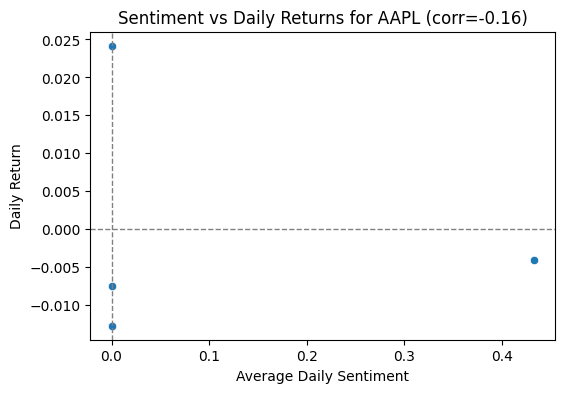

In [28]:
plt.figure(figsize=(6,4))
sns.scatterplot(
    data=merged,
    x="avg_daily_sentiment",
    y="daily_return"
)
plt.axhline(0, color="grey", linestyle="--", linewidth=1)
plt.axvline(0, color="grey", linestyle="--", linewidth=1)
plt.title(f"Sentiment vs Daily Returns for {ticker} (corr={corr_value:.2f})")
plt.xlabel("Average Daily Sentiment")
plt.ylabel("Daily Return")
plt.show()


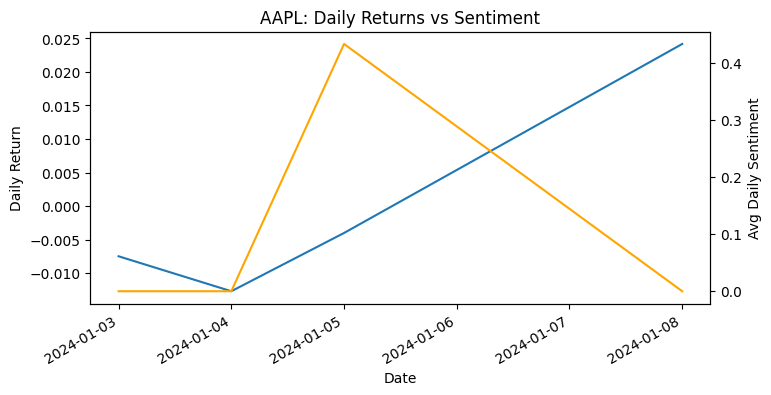

In [29]:
fig, ax1 = plt.subplots(figsize=(8,4))

ax1.plot(merged["date"], merged["daily_return"], label="Daily Return")
ax1.set_ylabel("Daily Return")
ax1.set_xlabel("Date")

ax2 = ax1.twinx()
ax2.plot(merged["date"], merged["avg_daily_sentiment"], color="orange", label="Avg Sentiment")
ax2.set_ylabel("Avg Daily Sentiment")

fig.autofmt_xdate()
plt.title(f"{ticker}: Daily Returns vs Sentiment")
plt.show()


In [30]:
merged.to_csv("../data/news_stock_merged.csv", index=False)
merged


,date,avg_daily_sentiment,daily_return
1,2024-01-03,0.000000,-0.007488
2,2024-01-04,0.000000,-0.012700
3,2024-01-05,0.433333,-0.004013
4,2024-01-08,0.000000,0.024175


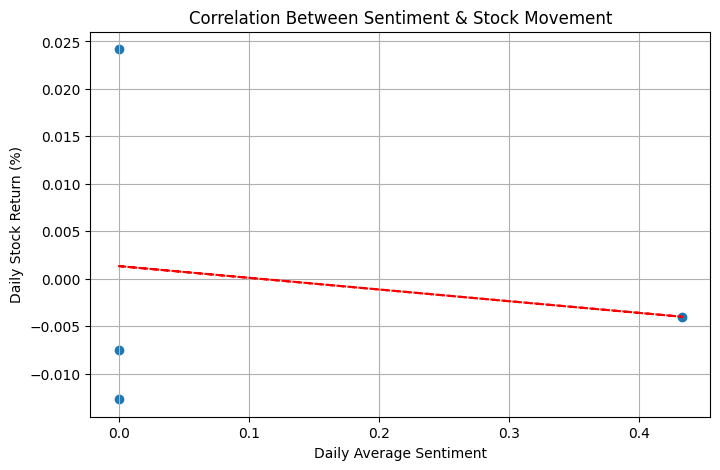

In [31]:
import matplotlib.pyplot as plt
import numpy as np

x = merged["avg_daily_sentiment"]
y = merged["daily_return"]

plt.figure(figsize=(8,5))
plt.scatter(x, y)

# Trendline
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x), "r--")

plt.xlabel("Daily Average Sentiment")
plt.ylabel("Daily Stock Return (%)")
plt.title("Correlation Between Sentiment & Stock Movement")
plt.grid(True)
plt.show()


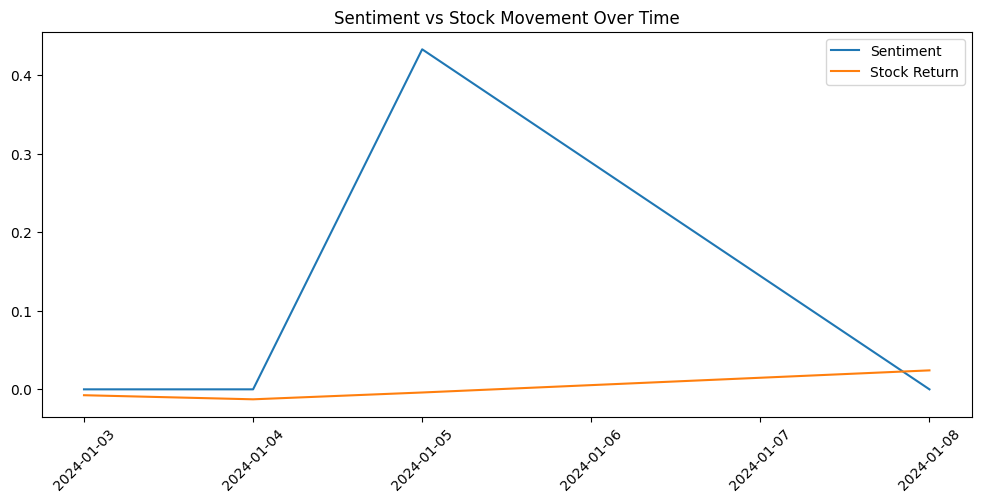

In [32]:
plt.figure(figsize=(12,5))
plt.plot(merged["date"], merged["avg_daily_sentiment"], label="Sentiment")
plt.plot(merged["date"], merged["daily_return"], label="Stock Return")
plt.legend()
plt.title("Sentiment vs Stock Movement Over Time")
plt.xticks(rotation=45)
plt.show()
